### Class Definition

In [105]:
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.optimize import dual_annealing
import matplotlib.pyplot as plt
import warnings
import random
import math

class pipeline_reduction(object):
    'Reduces the number of sections in a pipeline / flowline for increased simulation speed.'
    
    def __init__(self, df, xlabel = 'X', ylabel = 'Y', min_weld_size = 12.5, n_pipe_sec = 200):
        'Purpose: Initialises the pipeline_reduction class utility.'
        'Inputs:'
        'df: A Pandas dataframe object with the original pipeline profile data;'
        'xlabel: X axis label, default is X;'
        'ylabel: Y axis label, default is Y;'
        'min_weld_size: Resamples the original pipeline profile data to a minimum size size prior to further reduction;'
        'n_pipe_sec: Required number of final pipeline sections.'
        'Returns: N/A'
        
        #Initialise local variables
        self.df_raw = df
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.min_weld_size = min_weld_size
        self.n_pipe_sec = n_pipe_sec
        self.xstart = df[xlabel].iloc[0]
        self.xend = df[xlabel].iloc[-1]
        self.ystart = df[ylabel].iloc[0]
        self.yend = df[ylabel].iloc[-1]
                
    def _process_df(self, df, interp = True, **kwargs):
        'Purpose: Process input Pandas dataframe for discretisation.'
        'Inputs:'
        'df: A Pandas dataframe object with pipeline profile data;'
        '*args: Required pipe section length if re-sampling;'
        'interp: Resample dataset to a new pipeline length.'
        'Returns: Pandas dataframe object with resampled data.'
        
        #Make a copy of the original dataframe
        df = df.copy()
        
        #Calculate DelX and DelY
        if 'X_Del' not in df.columns:
            df['X_Del'] = df[self.xlabel] - df[self.xlabel].shift(1)
        else:
            df[self.xlabel] = df['X_Del'].cumsum() + self.xstart
            df.at[0, self.xlabel] = self.xstart
        
        if 'Y_Del' not in df.columns:
            df['Y_Del'] = df[self.ylabel] - df[self.ylabel].shift(1)
        else:
            df[self.ylabel] = df['Y_Del'].cumsum() + self.ystart
            df.at[0, self.ylabel] = self.ystart
        
        #Calculate length of each segment
        if 'pipe_len' not in df.columns:
            df['pipe_len'] = np.sqrt(df['X_Del']**2 + df['Y_Del']**2)
        
        # calculate pipeline length
        df['Length'] = df['pipe_len'].cumsum() + self.xstart
        df.at[0, 'Length'] = self.xstart
        fl_length = df['Length'].iloc[-1]
        
        #Perform 1-D interpolation
        length = df['Length'].values
        Y = df[self.ylabel].values
    
        if interp == True:
            new_size = kwargs['new_size']
            curr_min = min(df['pipe_len'].iloc[1:])
            if curr_min > new_size: #Check that current min. pipe length > new_size
                warnings.warn(f'Warning. Minimum pipe section is larger than the specified pipe section. Reseting to {curr_min}')
                new_size = curr_min
            length_new = np.arange(self.xstart, fl_length+new_size, new_size) # Reduced pipeline length
            length_new[-1] = fl_length
            f = interpolate.interp1d(length, Y) # Scipy Interpolation Function
            Y_new = f(length_new)
        else:
            length_new = length
            Y_new = Y
        
        #Add data to new dataframe
        #length_new = pd.Series(length_new)
        #Y_new = pd.Series(f(length_new)) # Calculate y values for reduced length
        
        # Store to new dataframe
        df_new = pd.DataFrame()
        df_new['Length'] = length_new
        df_new[self.ylabel] = Y_new
        df_new['pipe_len'] = df_new['Length'] - df_new['Length'].shift(1)
        df_new['Y_Del'] = df_new[self.ylabel] - df_new[self.ylabel].shift(1)
        df_new['X_Del'] = np.sqrt(df_new['pipe_len']**2 - df_new['Y_Del']**2)
        df_new[self.xlabel] = df_new['X_Del'].cumsum() + self.xstart
        df_new.at[0, self.xlabel] = self.xstart
        
        # Calculate pipe angles using inverse the sine formula (theta = arcsin(O/H))
        df_new['Angles'] = np.arcsin(df_new['Y_Del'] / df_new['pipe_len']) * 180 / 3.141592653589793
        
        # Add pipe index
        df_new['pipe_idx'] = df_new.index 
        
        del df
        return df_new
    
    def _optimise(self):
        'Purpose: Discretise and optimise the provided pipeline profile data.'
        'Inputs: N/A'
        'Outputs: N/A'
        
        # Resample dataset to min. specified weld size
        self.df_raw = self._process_df(self.df_raw, interp = True, new_size = self.min_weld_size)
                
        # Calculate size of each pipe section for dicretisation
        length = self.df_raw['Length'].iloc[-1]
        pipe_size_ds = length / self.n_pipe_sec
        
        # Generate a temp. discretised dataset, save best 'Y' values, sort by angles and save pipeline indices
        df_inp = self._process_df(self.df_raw, interp = True, new_size = pipe_size_ds)
        y_best = df_inp[self.ylabel].values
        df_inp[1:] = df_inp[1:].sort_values(by = 'Angles').values
        best_idx = df_inp['pipe_idx'].values / (len(df_inp) - 1)
        
        # Generate the elevation profile by sorting angles from smallest to largest
        df_ep = self.df_raw.copy()
        df_ep[1:] = df_ep[1:].sort_values(by = 'Angles').values
        
        # Interpolate over elevation profile, which conserves the overall angle class distribution
        df_ep = self._process_df(df_ep, interp = True, new_size = pipe_size_ds)
                       
        # Optimise overall pipeline profile
        # Get best mse values
        #mse_best = self._mse(df_ep, best_idx, y_best)
        
        # Optimiser algorithm
        #best_idx, mse_best = self._simulated_anneal(df_ep, mse_best, best_idx, y_best)
        bounds = [(0, 1) for i in range(0, len(df_ep))]
        result = dual_annealing(self._mse, bounds, x0 = best_idx, args = (df_ep, y_best), maxiter = 100)
        
        # Estimate new optimised discretised pipeline profile
        df_ep['pipe_idx'] = result.x
        df_ep[1:] = df_ep[1:].sort_values(by = 'pipe_idx').values
        self.df_op = self._process_df(df_ep, interp = False)
        #self.mse = mse_best
        
    def _angle_dist(self, df, bins):
        pass
    
    def _mse(self, pipe_idx, *args):
        'Purpose: Calculate the mean square error between the current profile and ideal elevation profile.'
        'Inputs:'
        'df: A Pandas dataframe with discretised pipeline profile data;'
        'pipe_idx: New pipeline profile indices;'
        'y_best: Best elevation profile.'
        'Returns:'
        'mse: Mean squared error between y_best and y_curr.'
        
        df = args[0]
        y_best = args[1]
        
        # Apply new pipeline index and sort
        df = df.copy()
        df['pipe_idx'] = pipe_idx
        df[1:] = df[1:].sort_values(by = 'pipe_idx').values
        df[self.ylabel] = df['Y_Del'].cumsum() + self.ystart
        df.at[0, self.ylabel] = self.ystart
        
        # Calculate mse
        y_curr = df[self.ylabel].values
        mse = np.sum(np.sqrt((y_best - y_curr)**2)) / (len(df) - 1)
        
        del df
        return mse

### Unit Tests

In [106]:
PATH = "../data"
df = pd.read_csv(f'{PATH}/profile.csv')

In [107]:
pru = pipeline_reduction(df)

In [108]:
pru._optimise()

In [109]:
pru.df_op

,Length,Y,pipe_len,Y_Del,X_Del,X,Angles,pipe_idx
0,0.000000,-919.090000,NaN,NaN,NaN,0.000000,NaN,0
1,64.310859,-918.471440,64.310859,0.618560,64.307884,64.307884,0.551095,1
2,128.621718,-918.036951,64.310859,0.434489,64.309391,128.617276,0.387097,2
3,192.932578,-917.913236,64.310859,0.123715,64.310740,192.928016,0.110220,3
4,257.243437,-918.032597,64.310859,-0.119361,64.310748,257.238765,-0.106341,4
5,321.554296,-918.233278,64.310859,-0.200681,64.310546,321.549311,-0.178791,5
6,385.865155,-918.157219,64.310859,0.076059,64.310814,385.860125,0.067762,6
7,450.176015,-917.902963,64.310859,0.254257,64.310357,450.170482,0.226523,7
8,514.486874,-917.851615,64.310859,0.051347,64.310839,514.481320,0.045746,8
9,578.797733,-917.623411,64.310859,0.228204,64.310454,578.791775,0.203312,9


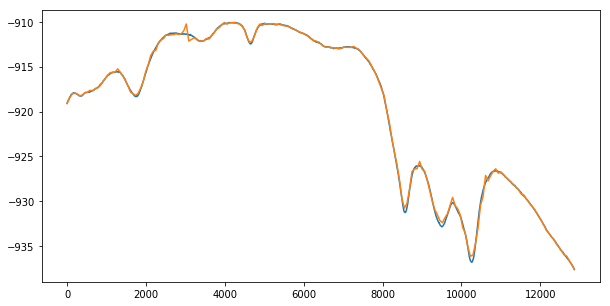

In [110]:
plt.figure(figsize=(10,5))
#plt.plot(df['Length'], df['Y'])
plt.plot(pru.df_raw['X'], pru.df_raw['Y'])
plt.plot(pru.df_op['X'], pru.df_op['Y'])
plt.show()

In [111]:
pru.mse

AttributeError: 'pipeline_reduction' object has no attribute 'mse'

In [3]:
random.uniform(0, 1)

0.35465557781313817

In [11]:
math.exp(-100/10)

4.5399929762484854e-05

In [78]:
def test(x, *args):
    print(x)
    for arg in args:
        print(arg)

In [79]:
test(5, 3, 6, 9)

5
3
6
9
